# Pathfinder tests

The goal of this module is to test the functionality of the pathfinder modules using the pre-saved data from the fullscan pathfinder.

In [22]:
import numpy as np
import logging
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
import json
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator
from logging.handlers import RotatingFileHandler
from logging import Formatter

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..\\')
from Pathfinders import *

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def logger_setup() -> logging.Logger:
    date_time_str = time.strftime(r"%Y-%m-%d_%H-%M-%S")

    # Configure the root logger to a particular folder, format, and level.
    # Lower the level when things are working better or worse.
    root_logger = logging.getLogger()
    path = os.path.dirname('..\\')
    
    handler = RotatingFileHandler(filename=path+f"\\logging\\runtime_test.log",
        backupCount=8,encoding="utf-8")
    handler.doRollover()

    formatter = Formatter(fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)
    root_logger.setLevel(logging.DEBUG)
    logger = logging.getLogger(__name__)
    logger.info("Debug log for the robot starting on " + date_time_str)
    return logger

# logger = logger_setup()

### Unload the data from a particular scan
This should only include data from a Fullscan module

In [24]:
path = os.path.abspath('..\\')
test_no = 13
# current_file = r"\Debugging Scripts\Scans\test_%s.json" % test_no
current_file = r"\Scans\OCE_Scans\oce_test_%s.json" % test_no

debug_mode = True

### JSON Unpacking
Using the above file number and path, the scan data is unpacked from the corresponding JSON file. Unpacking the data can take around ~15 seconds depending on the length of the file, so a #TODO item is to create code for running a pathfinder directly off a math equation.

In [25]:
with open(path + current_file, 'r') as infile:
    json_data = json.load(infile)

r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
point_mags = json_data["points"]
scan_max = np.array(json_data["max_point"])

if 'data_channels' in json_data.keys():
    num_channels = json_data['data_channels']
    data_labels = ['slope', 'intercept']
else:
    num_channels = 1

# indices = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
# points = np.array([[p[0][indices[a][0]][indices[a][1]] for a in active_rom] for p in point_mags])
# mags = np.array([p[1] for p in point_mags])

points = np.array(point_mags)
active_rom = json_data["active_ROM"]
cols = active_rom.copy()
[cols.append(i) for i in data_labels]

data = pd.DataFrame(data=points, columns=cols)

points = data[active_rom]
# mags = data['mag']
# mp = data.loc[data['mag'].idxmax()]

slopes = data['slope']
intercepts = data['intercept']
mp = data.loc[1798]

In [26]:
print(points.shape)
print(slopes.shape)
slopesLinInter = LinearNDInterpolator(points,slopes,fill_value=-1)
intsLinInter = LinearNDInterpolator(points,intercepts,fill_value=-1)

r = dict()
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2

if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(point_mags[0])
    print(type(point_mags))
    print(r_o_m)
    print(np.shape(points))
    print(r)
    print(resolution)
# Usually takes about 25 seconds for test_6

(4047, 3)
(4047,)
Active range of motion: ['Z', 'Rx', 'Ry']
[-0.7, -1.3636363636363638, -5.0, 0.02592, 96.20365]
<class 'list'>
{'X': [0, 0], 'Y': [0, 0], 'Z': [-2.5, 2.5], 'Rx': [-5, 5], 'Ry': [-5, 5], 'Rz': [0, 0]}
(4047, 3)
{'X': 0.0, 'Y': 0.0, 'Z': 2.5, 'Rx': 5.0, 'Ry': 5.0, 'Rz': 0.0}
[0.1, 0.88]


In [40]:
# scanner = Discrete_degree(r['Z'], r['Rx'], r['Ry'])
# scanner = DivisionDiscreteDegree(4, r['Z'], r['Rx'], r['Ry'], cutoff_mag=50)
ex = 2
# scanner = GradientAscent(r['Z']*ex,r['Rx']*ex,r['Ry']*ex,
#         bias=5,steps=4,traverse=1.6,inc=0.75)

# scanner = EllipsoidFullScan(resolution,r['Z'], r['Rx'],r['Ry'])
scanner = Greedy_discrete_degree(r['Z'], r['Rx'], r['Ry'], data_channels=1, inc=0.2)

p = scanner.next()
i = 0

offset = np.array([0,0,-0.4,-3.5,3.5,0])

a,b = 2,50

# My program will try to maximize this function:
def loss_function(slope, intercept):
    return 1000 - a*(np.abs(intercept - 150)) - b*np.abs(slope)


while type(p) is not int and i < 2500:
    i += 1
    # print(p)

    request = p + offset
    request = request[scanner.save_indices[0:-1]]

    # mag = linInter(request)
    slope = slopesLinInter(request)
    intercept = intsLinInter(request)
    mag = loss_function(slope,intercept)

    if mag == -1:
        mag = i * -20
    # print(f"magnitudes:{mag}")
    # print(f"Value pushed:\t\t\t{np.append(p,mag)}")

    scanner.newMag(np.append(p,mag))
    # print(f"Mag: {mag}\t\tpoint:\t{np.append(p,mag)},\t\tLoop {i}                              ",end="\n")
    p = scanner.next()
    # print('\n'.join(prin), end=(len(prin) + 1)*'\033[F')

print()
print(p)
if debug_mode:
    print(f"Number of points to solve: {i}")
    # print(path + output_file)

point_mags_2 = scanner.points
search_max = scanner.max_point
active_rom = scanner.active_rom

cols = active_rom.copy()
cols.append("mag")

print(len(point_mags_2))

scanner_dat = np.array(scanner.points)

scanner_data = pd.DataFrame(data=scanner_dat, columns=cols)

print(scanner_data.head())
a = np.array(point_mags_2[0])
distance = 0

for i in range(1, len(point_mags_2)):
    b = np.array(point_mags_2[i])
    t = np.sum((b - a)**2)

    distance += t**0.5
    a = b

# (x,y,z,Rx,Ry,Rz,mag) = search_max.tolist()
# search_max = (((x+offset['X'],y+offset['Y'],z+offset['Z']),(Rx+offset['Rx'],Ry+offset['Ry'],Rz+offset['Rz'])),mag)
search_max = search_max + np.append(offset.copy(),0)

t = np.sum((scan_max[:3] - search_max[:3])**2)
lin_dist = t**0.5

degree_dist = np.arccos(np.cos(np.deg2rad(scan_max[3] - search_max[3])) 
            * np.cos(np.deg2rad(scan_max[4] - search_max[4])))

request = search_max[0:-1]
print(request)
slope = slopesLinInter(request)
intercept = intsLinInter(request)


print("Pathfinder evalutation: ")
print(f"\tTotal search-space distance traveled: {distance}")
print(f"\tScan max value:\t\t{scan_max}")
print(f"\tSearch max value:\t{search_max}")
print(f"\tSlope and intercept at that point: y = {slope}x + {intercept}")
print(f"\tOffsets: {offset}")
print(f"\tDistance from target to found value: {lin_dist} mm, {degree_dist} deg")


1
Number of points to solve: 27
27
     Z   Rx   Ry         mag
0  0.0  0.0  0.0  947.294520
1  0.0  0.0  0.0  947.294520
2 -0.1  0.0  0.0  965.068357
3 -0.2  0.0  0.0  978.591475
4 -0.3  0.0  0.0  956.633533
[ 0.000  0.000 -0.600 -3.500  3.500  0.000]
Pathfinder evalutation: 
	Total search-space distance traveled: 416.274209636283
	Scan max value:		[ 0.000  0.000 -1.300 -3.182 -2.273  0.000  1.719 -87.612]
	Search max value:	[ 0.000  0.000 -0.600 -3.500  3.500  0.000  978.591]
	Slope and intercept at that point: y = [ 0.063 -1.000]x + [ 154.979 -1.000]
	Offsets: [ 0.000  0.000 -0.400 -3.500  3.500  0.000]
	Distance from target to found value: 0.6999999999999997 mm, 0.10090550850108157 deg


In [29]:
scanner_data

,Z,Rx,Ry,mag
0,0.0,0.0,0.0,980.617430
1,0.0,0.0,0.0,980.617430
2,-0.1,0.0,0.0,986.388003
3,-0.2,0.0,0.0,993.539741
4,-0.3,0.0,0.0,917.767272
5,-0.4,0.0,0.0,872.848136
6,-0.5,0.0,0.0,803.322472
7,-0.1,0.0,0.0,986.388003
8,0.0,0.0,0.0,980.617430
9,0.1,0.0,0.0,930.514235


KeyError: 'mag'

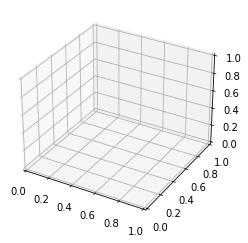

In [28]:
ax = plt.axes(projection='3d')

cmap = plt.cm.viridis # Choose colormap
my_cmap = cmap(np.arange(cmap.N)) # Get the colormap colors
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)*0.8 # Set alpha
my_cmap = ListedColormap(my_cmap) # Create new colormap

fig = ax.scatter(data['Rx'], data['Ry'], data['Z'], c=data['mag'], cmap=my_cmap, linewidth=0.02)
plt.colorbar(fig, pad=0.13,alpha=1)

# fig = ax.scatter(Rxs1, Rys1, Zs1, c=range(len(Zs1)), cmap='binary', alpha=0.8, linewidth=0.8, s=4)
fig = ax.scatter(scanner_data['Rx'], scanner_data['Ry'], scanner_data['Z'], c=range(len(scanner_data)), cmap='cool', alpha=0.8, linewidth=0.8, s=4)

ax.set_xlabel("Rx (deg)")
ax.set_ylabel("Ry (deg)")
ax.set_zlabel("z (mm)")
plt.rcParams['figure.dpi'] = 200

print((min(scanner_data['Rx']),max(scanner_data['Rx'])))
print((min(scanner_data['Ry']),max(scanner_data['Ry'])))
print((min(scanner_data['Z']),max(scanner_data['Z'])))

# ax.set_xbound((min(scanner_data['Rx']),max(scanner_data['Rx'])))
# ax.set_ybound((min(scanner_data['Ry']),max(scanner_data['Ry'])))
# ax.set_zbound((min(scanner_data['Z']),max(scanner_data['Z'])))

# plt.savefig("fullscan_render.jpg", dpi=400)
plt.show()
# plt.axes(projection = "3d")
# plt.scatter(Rxs, Rys, Zs, c=mags, cmap='viridis', alpha=0.8, linewidth=0.5)


In [ ]:
# I want to check the optimal values for traverse distance, increment size, bias, and steps. This is gonna be rough.
(trav_min, trav_max, trav_step) = (0.8,2.4,4)
(inc_min, inc_max, inc_step) = (1.4,2.2,4)
(bias_min,bias_max,bias_step) = (0,18,4)
(step_min,step_max,step_step) = (1,7,4)

# var_comparison = pd.DataFrame(columns = ['Traverse','Increment', 'bias','step',
#     'Points_visited','final_max','max_mag'])

test_vars = np.mgrid[
    trav_min:trav_max:trav_step*1j,
    inc_min:inc_max:inc_step*1j,
    bias_min:bias_max:bias_step*1j,
    step_min:step_max:step_step*1j].reshape(4,-1).T

(z0,z1,zs) = (-2.4,7.0,3)
(Rx0,Rx1,Rxs) = (-13,13,3)
(Ry0,Ry1,Rys) = (-13,13,3)

offsets = np.mgrid[0:0:1j,
                    0:0:1j,
                    z0:z1:zs*1j,
                    Rx0:Rx1:Rxs*1j,
                    Ry0:Ry1:Rys*1j,
                    0:0:1j].reshape(6,-1).T

# offset = np.array([0,0,-3,-10,12,0])

print(test_vars.shape[0] * offsets.shape[0])

In [ ]:
# vc = pd.DataFrame(columns = ['offset','Traverse','Increment', 'bias','step',
#     'Points_visited','final_max','max_mag'])

# tot = test_vars.shape[0] * offsets.shape[0]

# i = 0
# for test_set in test_vars:
#     for offset in offsets:
#         start_time = time.time()
#         traverse=test_set[0]
#         inc=test_set[1]
#         bias=int(test_set[2])
#         step=int(test_set[3])

#         test = GradientAscent(r['Z']*ex,r['Rx']*ex,r['Ry']*ex,
#             bias=bias,steps=step,traverse=traverse,inc=inc)

#         p = test.next()
#         j=0
#         while type(p) is not int and j < 2000:
#             j += 1

#             request = p + offset
#             request = request[test.save_indices[0:-1]]
#             # print(f"Reuqest: {request}")
#             mag = linInter(request)

#             if mag[0] == -1:
#                 mag[0] = i * -20
#             # print(f"magnitudes:{mag}")
#             # print(f"Value pushed: {np.append(p,mag[0])}")

#             test.newMag(np.append(p,mag[0]),True)
#             p = test.next()
#             if j % 50 == 0:
#                 print(f"Highest magnitude: {test.max_point[6]}\tLoop {j}\t\t\t",end="\r")
#             if type(p) is int:
#                 j = 2500
#         i+=1
#         vc.loc[len(vc.index)] = (offset,traverse,inc,bias,step,j,test.max_point,test.max_point[6])
#         print(f"Test ({i}/{tot}):({offset[test.save_indices[0:-1]]}),\ttrav={traverse:0.1f}\tinc={inc}\tbias={bias}\tstep={step}"
#             f"\tcompleted in {(time.time() - start_time):0.2f} seconds.\tMax mag found {test.max_point[6]:0.2f}")


In [ ]:
# print(vc.head())
# print(vc.tail())

path = os.path.abspath('..\\')
# test_no = 6
# current_file = r"\Debugging Scripts\Scans\test_%s.json" % test_no
current_file = path + r"\parameter_check2.csv"
print(current_file)

# vc.to_csv(current_file)

In [ ]:
param_dat = pd.read_csv(current_file)
# print(param_dat.columns)
param_dat = param_dat.drop('Unnamed: 0',axis=1)

# print(param_dat.head())

succ = param_dat[param_dat['max_mag'] > 600].reset_index(drop=True)
max = succ.loc[succ['max_mag'].idxmax()]

# print(succ[succ['Points_visited'] < 2000].reset_index(drop=True))
print(max)
# print(succ.to_string())
combos = succ[['bias','step','Traverse','Increment']].value_counts().reset_index(name='count')
combos.drop('count', axis=1, inplace=True)
print(combos.head())

row = combos.loc[[4]].values[0].tolist()
print(row)
# bias,step,trav,inc = row['bias'].values,row['step'],row['Traverse'],row['Increment']
bias,step,trav,inc = row

print()
averages = []


# print(combos.shape)
# print(combos.loc[[2]])
for i in range(combos.shape[0]):
    row = combos.loc[[i]].values[0].tolist()
    bias,step,trav,inc = row
    averages.append(np.mean(succ[np.all([succ['bias']==bias,
        succ['step']==step,succ['Traverse']==trav,
        succ['Increment']==inc],axis=0)]
        .reset_index(drop=True)['max_mag']))

combos['avg'] = averages
print(combos.head())
combos.sort_values('avg',axis=0,inplace=True,ascending=False)
print(combos.to_string())    

    

In [ ]:
a = []
for i in range(10):
    a.append(np.array([0,0,i]))

a = np.array(a)
print(a)

In [ ]:
A = np.eye(4)
A = np.diag([4,3,2,1])
b = np.array([1,2,3,4])

print(b.T@A@b)
print(A@b@b)